# Advanced Tutorial for the MFF Package <br/>

In this jupyter notebook, the main functionalities of MFF will be introduced and briefly explained. <br/>
As an example, we will train a Gaussian Process Fore Field on DFT data of molecular dynamics simulations of a Nickel 19 nanoparticle. 
Subsequently, the Gaussian process force field's accuracy will be tested and the scatter plot of errors will be shown.
Then we will map the trained Gaussian Process onto a non-parametric force field, which will finally be used to run very fast
molecular dynamics simulations using the ASE Python package.

In [1]:
# Standard Imports
import logging
import numpy as np
import matplotlib.pyplot as plt
# import ASE
from ase.io import read
from ase.io import write
from ase import Atoms
# Import MFF
from mff import utility, configurations, models, load_model, calculators
from pathlib import Path

%matplotlib notebook  
logging.basicConfig(level=logging.ERROR)  # Verbosity selection: INFO, WARNING or ERROR

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Extract local atomic environment data from a trajectory file
As a first step, we must transform data coming from an ab-initio run onto data which can be used as inputs and outputs for our force (and/ior energy) prediction problem. <br/>
To do so, we use the "configurations" module of MFF and save the transformed data onto an unsurprisingly named "data.npy" file. <br/>
The "data" file will contain informations about which elements are present in the system, a list of all local atomic environments carved using the specied cutoff radius, a list of all forces pertaining to the central atoms of said atomic environments, a collecion of the energies associated to each snapshot of the trajectory file, and a list that groups local atomic enviornments by snapsht necessary for total energy training and testing.

N.B.: Make sure that your trajectory xyz file has forces which are called "forces", and energies called "energy" for each snapshot, and that all units of measure are in Angstrom, eV and eV/Angstrom.
If this is not the case, remember to specify the force naming and energy naming convention in the funcion "extract data" below, and to multiply all data by the appropriate conversion if the units do not match the ones above.

In [5]:
directory = Path('data/Ni_19/')             # Path to the directory that contains the trajectory file, and where all of the files will be saved
filename = directory / 'movie.xyz'       # name of the trajectory file
cutoff = 6.4                              # Cutoff to be used to carve local atomic environemnts, in Angstrom


data = configurations.generate_and_save(filename, cutoff, forces_label='forces', energy_label='energy')   # Generate and save the compressed "data" object that contains all the information
elements, confs, forces, energies, global_confs = configurations.load_and_unpack(directory, cutoff) # Extract the information from the zipped data object which is located in the directory

## Choose training set

Here we will first set the number of training and test points we would like to use.
The training points can be chosen at random, or using the "grid2" and "grid3" sampling methods. 

Such methods try to include in the training database configurations which contain atomic distances (grid2) or unseen triplets of atomic distances (grid3) not yet present in the training database.


In [6]:
# Number of training points to use. NB: if training on forces AND energies, this number will
# be the number of force training points, the number of energy training points is determined byf_e_ratio 
training_points = 100      

# Number of test points to use. NB: if training on forces AND energies, this number will
# be the number of force training points, the number of energy training points is determined byf_e_ratio 
test_points = 100

# Sampling methodology used to select the training points. Options are: "random", "grid2" and "grid3". 
# N.B> when using "grid2" or "grid3" the effective number of points selected will slightly differ from the one indicated above.
sampling = "cna"

# Numberof bins to use in the "grid2" and "grid3" sampling methods. If left None, this will be utomatically chosen
# in order for the effective number of training points to match as closely as possible "training_points" 
nbins = None

# When using force AND energy training, the number of training points for the energy data will be training_points//f_e_ratio + 1.
# The number of energy testing points will be, similarly, test_points//f_e_ratio + 1.
f_e_ratio = 10

# Since we are using CNA sampling, we also have to explicitely load the  trajectory file from which the files originate
traj = read(filename, index = ':')

# And also choose the nearest neighbour cutoff for the CNA analysis
cna_cut = 3.0

# Get the training and test set for energy and force training. Capital letters refer to test set, small letters to traiing set. 
# X refer to input data (local atomic environemnts, total atomic environments), Y refer to output data (force, total energy.)
# Letters without subscript are relative to force training/testing, letters with _e are relative to energy training/testing
X, Y, X_e, Y_e, x, y, x_e, y_e = utility.sample_oneset(confs, forces, global_confs,
                energies, elements, sampling, training_points, test_points, cutoff, nbins, f_e_ratio, traj, cna_cut)

CNA classes are: 
 {(1, 0, 0): 304, (6, 6, 6): 532, (4, 4, 4): 760, (3, 0, 0): 4492, (5, 4, 4): 7164, (4, 2, 2): 9834, (2, 1, 1): 13388, (4, 3, 3): 29164, (4, 2, 1): 36248, (5, 5, 5): 64494, (2, 0, 0): 93060, (3, 1, 1): 100982, (3, 2, 2): 140226}


## Choose the GP hyperparameters, create the GP object and train it

In [7]:
# Choice of the kernel model to use. The options are: "2b", "combined", "3b". We suggest using "2b" for quick tests and "combined" for producing force fields.
kernel =  "2b"

# Choice of the kernel lengthscale parameter, in Angstroms. We suggest using values between 0.2 nand 1 Angstroms.
sigma = 0.5

# Choice of the noise  associated to the trainig data. Optimal results are usually obtained with noise values betwwe 1e-2 and 1e-4.
noise = 0.001

# Choose whether to train on force only, energies only or forces and energies
train_mode = "force"

# Number of cores to use in the training. The paralllelization of the code does not scale linearly with the number of cores,
# we therefore suggest using more than one core only when producing accurate force field with the "combined" kernel and more than 500 training points.
ncores = 1

# Create and train the Gaussian process object
m = utility.get_gp(directory, X, Y, elements, kernel, sigma, noise, cutoff, training_points, X_e, Y_e, train_mode, ncores)

Training using 100 points on 1 cores
Saved Gaussian process with name: data/Ni_19/models/GP_ker_TwoBodySingleSpecies_ntr_100.npy


## Test the GP, display scatter plots of the errors and print error metrics

Testing the force prediction on 100 configurations

RMSE: 0.1573 eV/A
MAEC: 0.1272 eV/A
MAEF : 0.2510 +- 0.1057 eV/A
Relative MAEF: 0.4065 +- 0.1712


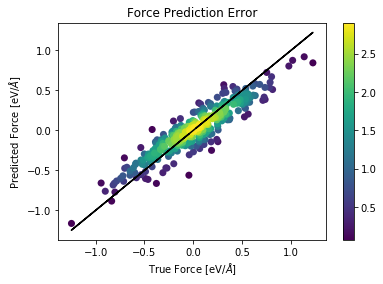

In [8]:
# Choose whether to test the GP predictions on forces only, energies only or forces and energies
test_mode = "force"

# Choose if you want to obtain the scatter plot of the errors incurred by the Gp
plot = True

# Get the error metrics (which are also printed on screen) calculated on the test points
MAE_c, MAE_f, SMAE_f, M_f, RMSE_f, MAE_e, SMAE_e, RMSE_e = utility.test_gp(m, x, y, x_e, y_e, plot, test_mode)

## Map the Gp force field onto a non-parametric classical tabulated force field

In [9]:
# number of points to use while avaluating the tabulated force field. We reccomend using 100 points for "2b" kernels
# And at least 80 points for "3b" kernels. Combined kernels require a specification of the number of points to use
# for the 2-body grid and for the 3-body grid separately.
npoints_grid = 100

# Minimum  Interatomic distance for which to build a mapped potential. If the distance is not 0, 
# MD simulations where atoms become closer than this value value will cause an errorand interrupt the simulation.
# Despite this, it is useful to use values larger than 0 to increase mapping accuracy by making the grid of tabbed values denser.
# This is especially true for more computationally expensive grid constructions, such as the "3b" and "combined" ones.
grid_start = 1.5

# Build the mapped force field
m.build_grid(grid_start, npoints_grid)  # Map the Gaussian process to build a MFF

## Save the model, the trained Gaussian process and, most importantly, the mapped potential
This function can be used also to save the trained model before mapping the potential.

In [10]:
m.save(directory / "models")

Saved Gaussian process with name: data/Ni_19/models/GP_ker_TwoBodySingleSpecies_ntr_100.npy


## Load the model, whether it contains a GP or a mapped potential

Loaded GP from file
Testing the force prediction on 100 configurations

RMSE: 0.1573 eV/A
MAEC: 0.1272 eV/A
MAEF : 0.2510 +- 0.1057 eV/A
Relative MAEF: 0.4065 +- 0.1712


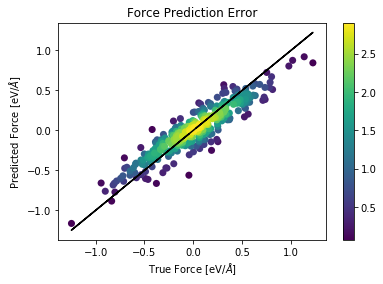

In [11]:
m2 = load_model.load("data/Ni_19/models/MODEL_ker_TwoBodySingleSpecies_ntr_100.json")

# Check the model is effectively the same
vMAE_c, MAE_f, SMAE_f, M_f, RMSE_f, MAE_e, SMAE_e, RMSE_e = utility.test_gp(m2, x, y, x_e, y_e, plot, test_mode)

## Setup Simulation parameters in ASE

In [12]:
# Additional ASE imports
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.velocitydistribution import Stationary
from ase.md.velocitydistribution import ZeroRotation
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units
from ase.io import extxyz

# Global Variables Definition
gamma = 0.001 #  For Langevin Dynamics
temp = 500 # K
dt = 1.0  # fs
cell_length = 10.0 # Angstrom

atoms = read(filename, index=0, format='extxyz')  # Read the input file and setup the initial geometry form the xyz file
atoms.set_positions(atoms.get_positions() - 0.5*np.array([cell_length, cell_length, cell_length]))  # Center atoms in the cell
atoms.set_cell([[cell_length, 0.0, 0.0], [0, cell_length, 0], [0, 0, cell_length]]) # Set the simulation cell if not present

## Setup an ASE Calculator to use the MFF to run simulations

In [13]:
mff_calc = calculators.TwoBodySingleSpecies(cutoff, m.grid)  # Initialize calculator module
atoms.set_calculator(mff_calc) # Tell ASE how to get the forces ( AKA choose the potential)

# Setup the momenta and velocities
dyn = VelocityVerlet(atoms, dt * units.fs)  # The dynamics will be a Verlet one
MaxwellBoltzmannDistribution(atoms, 2.0 * temp * units.kB)  # Initialize velocities according to MB distribution at double T because of equipartition theorem
ZeroRotation(atoms)  # Stop global rotation
Stationary(atoms)  # Stop global movement

## Auxiliary functions for the simulation

In [14]:
def printenergy(a=atoms):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
def savexyz(a=atoms):
    this_traj = open(output_name, "a")
    extxyz.write_extxyz(this_traj, [atoms])

## Run the simulation

In [18]:
steps = 1000

output_name = "data/Ni_19/trajectory_mff.xyz"  # Output name
this_traj = open(output_name, "w")
dyn.attach(savexyz, interval=100)  # Save coordinates every interval steps
dyn.attach(printenergy, interval=100)  # Print informations every interval steps
dyn.run(steps)  # Have fun
this_traj.close()

/opt/conda/lib/python3.6/site-packages/ase/io/extxyz.py:844: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  'from calculator'.format(key))


Energy per atom: Epot = -2.613eV  Ekin = 0.060eV (T=463K)  Etot = -2.554eV
Energy per atom: Epot = -2.613eV  Ekin = 0.060eV (T=463K)  Etot = -2.554eV
Energy per atom: Epot = -2.632eV  Ekin = 0.069eV (T=534K)  Etot = -2.563eV
Energy per atom: Epot = -2.632eV  Ekin = 0.069eV (T=534K)  Etot = -2.563eV
Energy per atom: Epot = -2.601eV  Ekin = 0.054eV (T=415K)  Etot = -2.547eV
Energy per atom: Epot = -2.601eV  Ekin = 0.054eV (T=415K)  Etot = -2.547eV
Energy per atom: Epot = -2.641eV  Ekin = 0.074eV (T=569K)  Etot = -2.567eV
Energy per atom: Epot = -2.641eV  Ekin = 0.074eV (T=569K)  Etot = -2.567eV
Energy per atom: Epot = -2.597eV  Ekin = 0.052eV (T=400K)  Etot = -2.545eV
Energy per atom: Epot = -2.597eV  Ekin = 0.052eV (T=400K)  Etot = -2.545eV
Energy per atom: Epot = -2.632eV  Ekin = 0.069eV (T=533K)  Etot = -2.563eV
Energy per atom: Epot = -2.632eV  Ekin = 0.069eV (T=533K)  Etot = -2.563eV
Energy per atom: Epot = -2.609eV  Ekin = 0.058eV (T=446K)  Etot = -2.551eV
Energy per atom: Epot = -